In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

# Objective
- Making a sense out of the data
- Perform EDA and data pre-processing to understand the data deeper 
- Scaling, Imputations, Clustering (t-SNE) 
- Choosing the suitable prediction algorithm with respect to the business goal


# Importing the credit card user datasets


In [16]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Understanding the data using Exploratory Data Analysis (EDA)
- Plotting the distribution of Fraud vs Non Fraud
- Identify skewness in the distribution (and normalizing it)

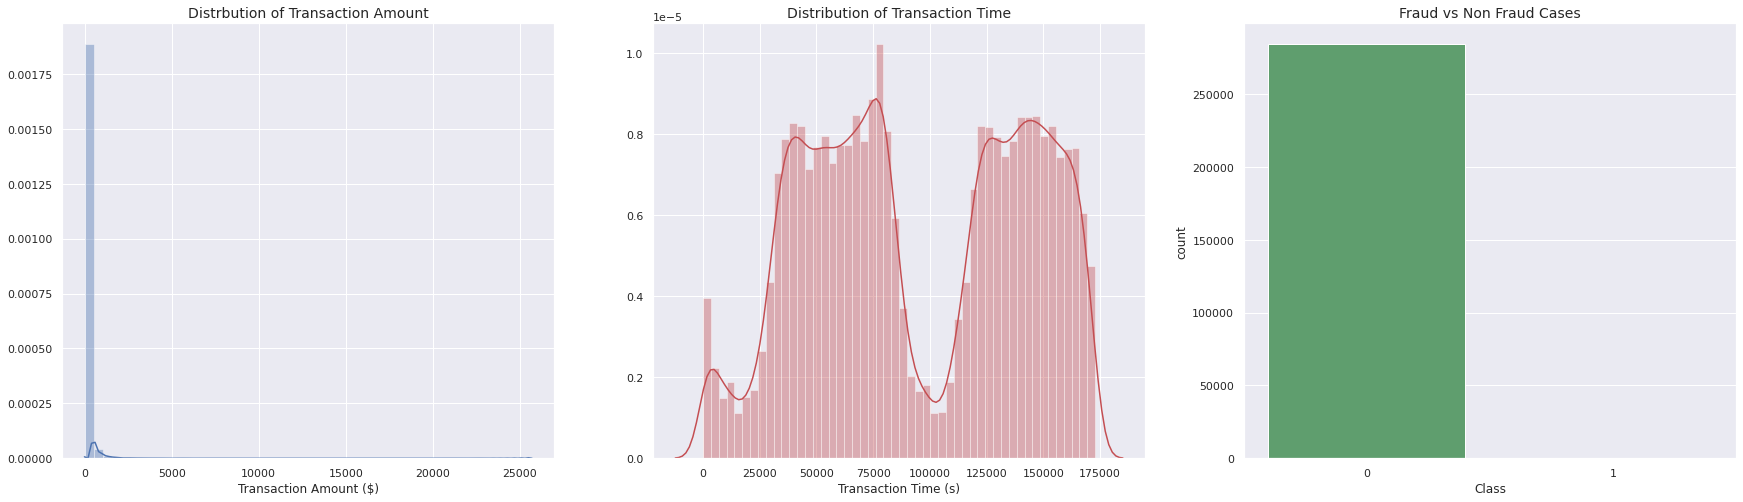

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(30,8))
sns.set(style="darkgrid")

# Some attributes
countTime = df['Time'].values
amount = df['Amount'].values
ax[0].set_title('Distrbution of Transaction Amount', fontsize=14)
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[2].set_title('Fraud vs Non Fraud Cases', fontsize=14)


# Plotting 3 simple EDA
sns.distplot(countTime, ax=ax[1], color='r', axlabel="Transaction Time (s)")
sns.distplot(amount, ax=ax[0], color='b', axlabel="Transaction Amount ($)")
sns.countplot(df['Class'], ax=ax[2], color='g')

#Finding correlations between features
 - Using the heatmap(), we can find some hidden correlations that might affect the data or find if there are any risk of multicollinearity issue

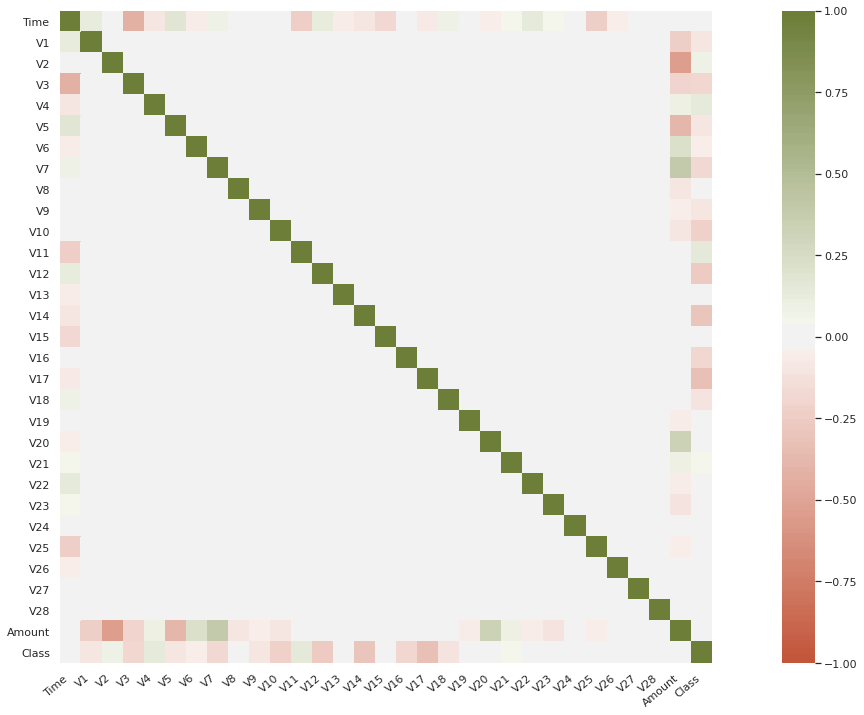

In [18]:
dfcorr = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(25,12))

# Create a heatmap() handler
ax = sns.heatmap(
    dfcorr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 100, n=150),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=40,
    horizontalalignment='right'
);

#Splitting and Scaling the data 
 - Scaling is done to prevent **overfitting**. There are many popular scaling techiniques such as mean and median.
 - Scaling is done to prevent **bias in correlation**. This help to make the model understand the strength of each feature, V
 - Source: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html

In [0]:
# For this use case, we would be using MinMaxScaler(). There are different scalers from the link above as well. 
scaler = MinMaxScaler()

# Scaling the Time and Amount values
df['Normal Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Normal Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
trueClass = df['Class'] # True class

In [0]:
splits = StratifiedKFold(n_splits=5, random_state=None, shuffle=False) # We do 5 times split to see the performance of model on all k-splits, and not just 1. 
X = df.drop('Class', axis=1)
y = df['Class']

# Splitting the df into a mix of X and y for train and test datasets
for trainIndex, testIndex in splits.split(X, y):
   original_Xtrain, original_Xtest = X.iloc[trainIndex], X.iloc[testIndex]
   original_ytrain, original_ytest = y.iloc[trainIndex], y.iloc[testIndex]

# Convert them into list
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

## Under sample the majority class
- Reducing the fraud class to only 100% of the non-fraud observations

In [0]:
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492] # Only taking half of the values

In [22]:
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

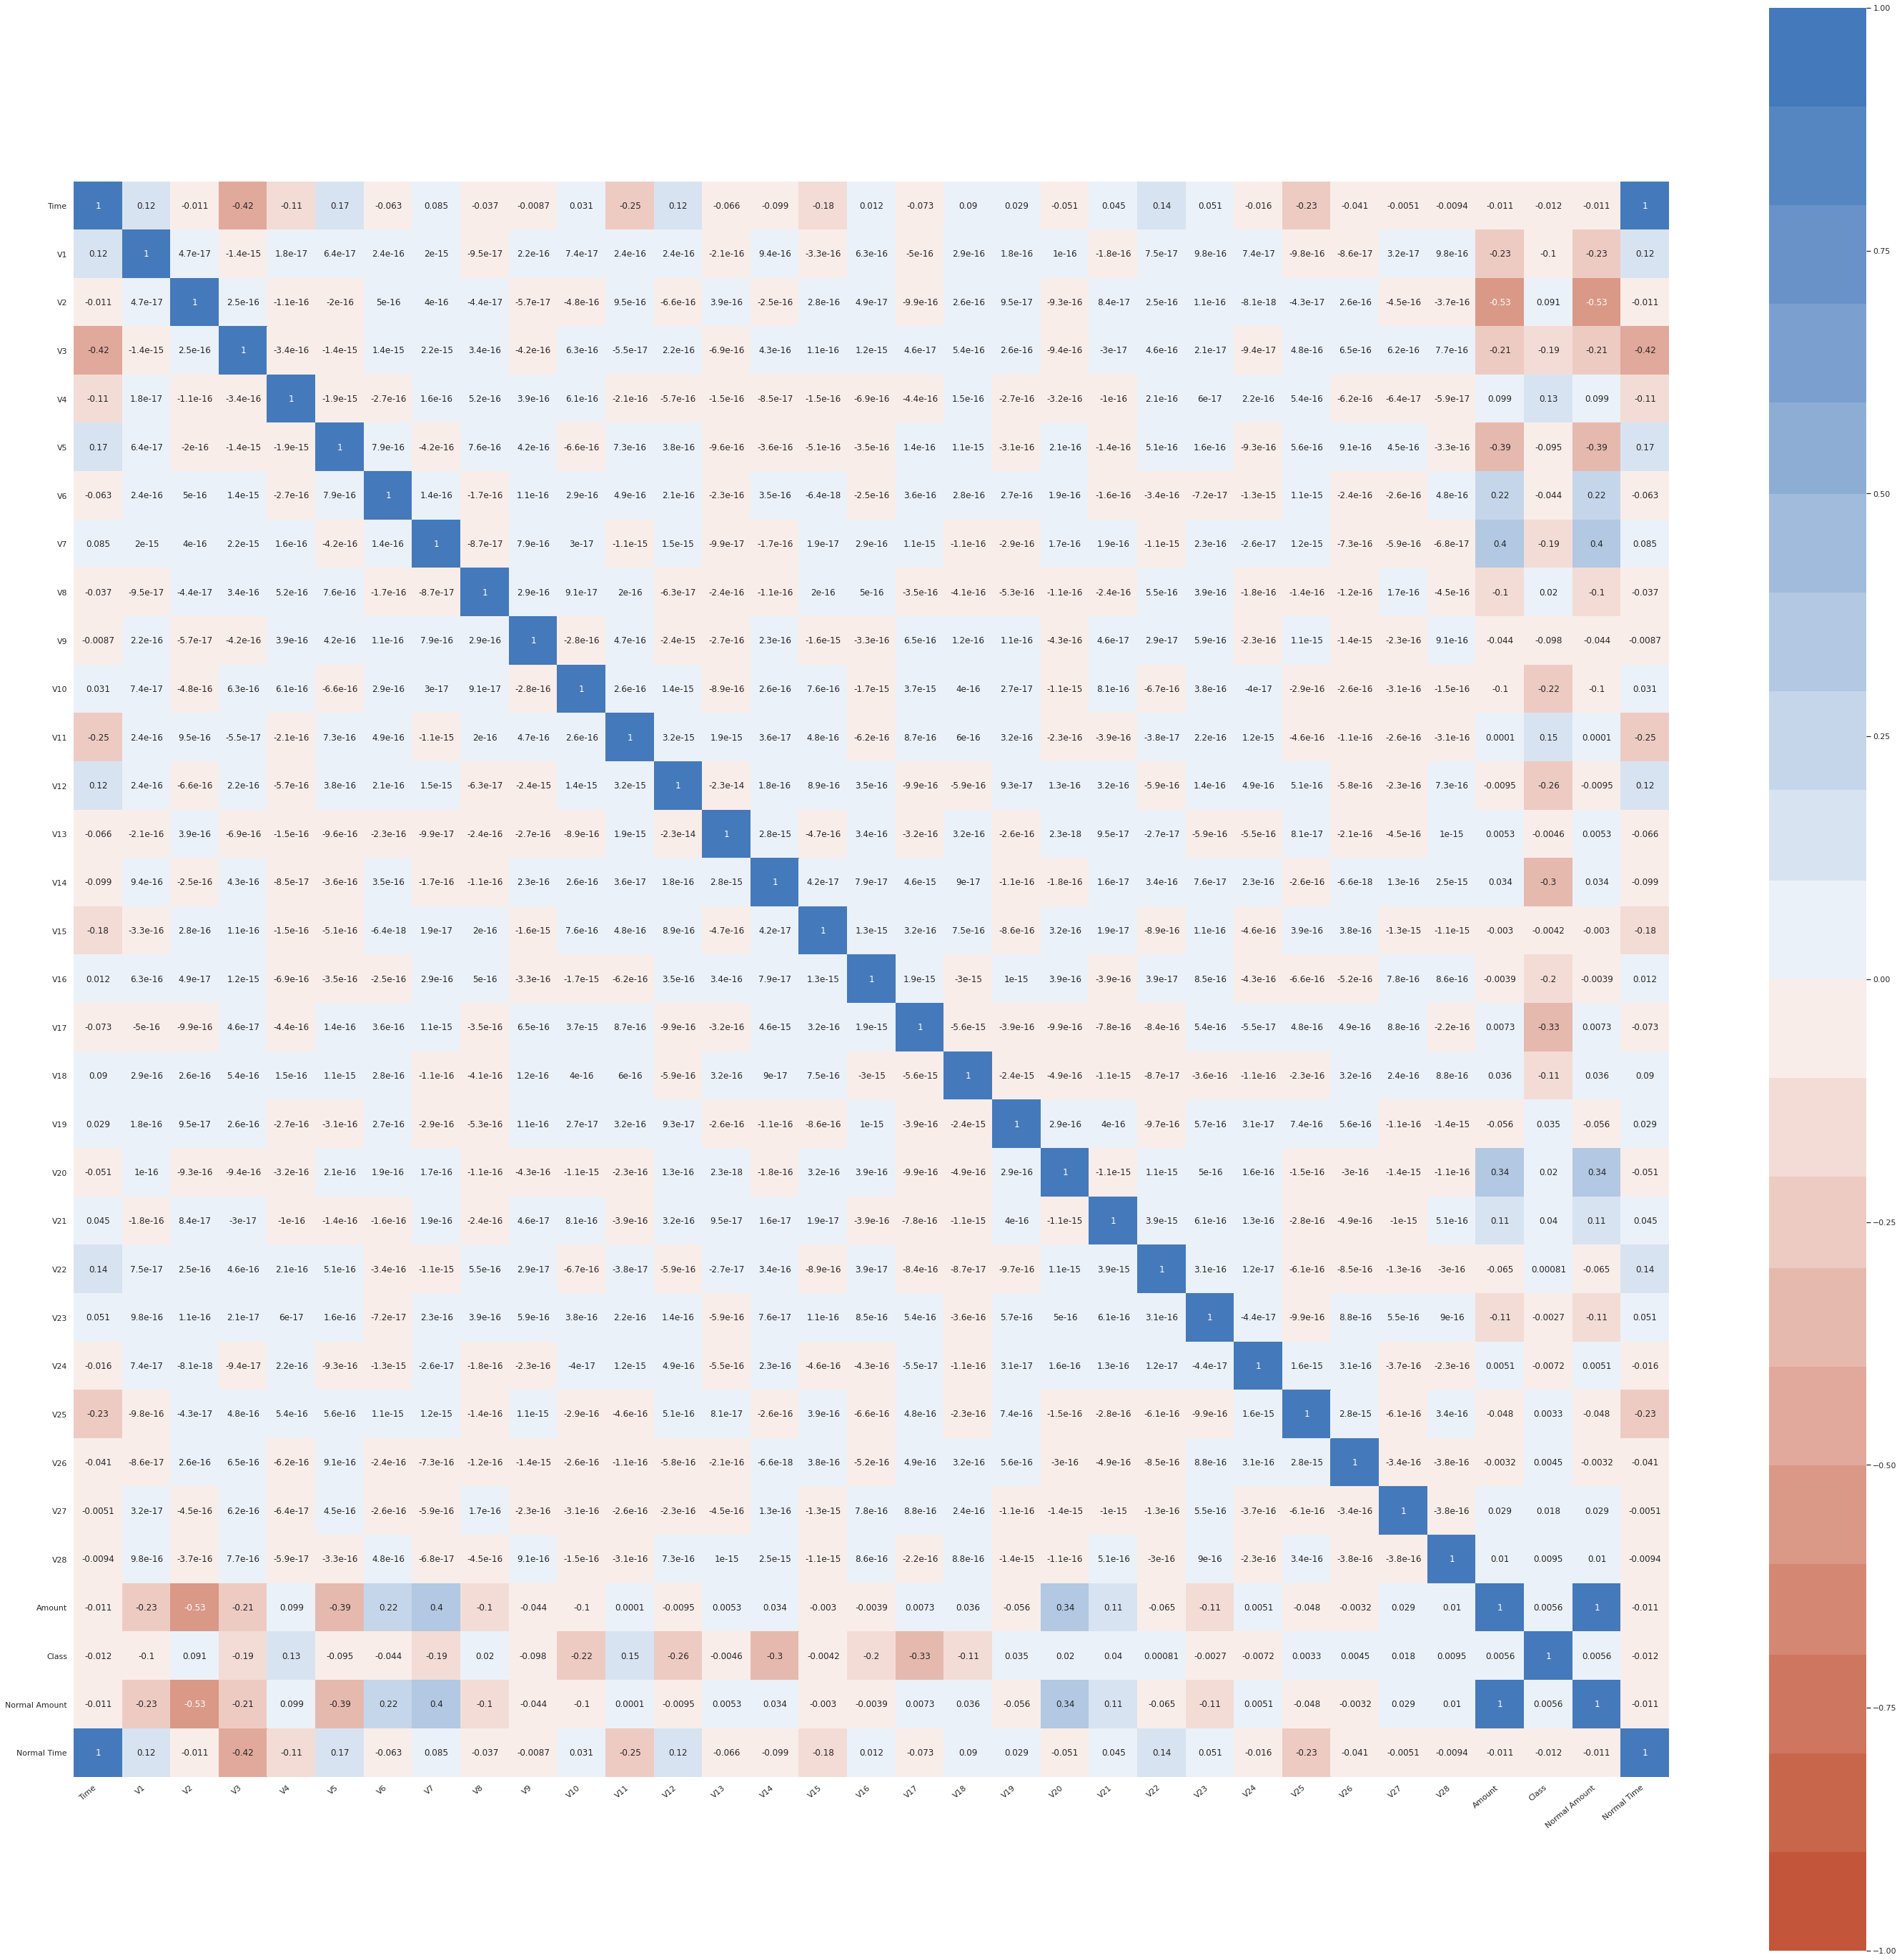

In [23]:
dfcorr = df.corr()
fig, ax = plt.subplots(1, 1, figsize=(50,50))

# Create a heatmap() handler
ax = sns.heatmap(
    dfcorr, 
    vmin=-1, vmax=1, center=0,
    annot=True,
    cmap=sns.diverging_palette(20, 250, n=20),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=40,
    horizontalalignment='right'
);

---


## Remove the outliers

- Using scatter plots, box plots or even Interquartile Range (IQR), we can visualise the distribution of the features to remove the outliers
- Implement a rational hard threshold to the data to remove the outliers
- From the correlation matrix, we can see that 4 features - V3, V4, V11, V12, V14, V17 have high correlation with the outcome of Class. This represents both Positive and Negative correlation. 


---



Text(0.5, 1.0, 'V11 vs Fraud Transaction')

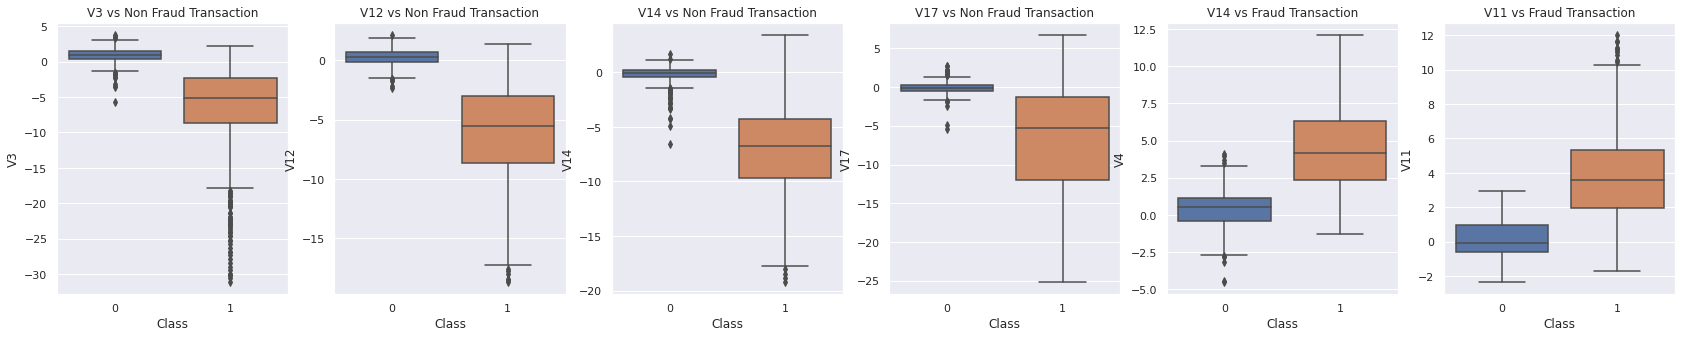

In [24]:
_, ax = plt.subplots(1, 6, figsize=(29,5))
sns.boxplot(x="Class", y="V3", data=new_df, ax=ax[0])
ax[0].set_title('V3 vs Non Fraud Transaction')

sns.boxplot(x="Class", y="V12", data=new_df, ax=ax[1])
ax[1].set_title('V12 vs Non Fraud Transaction')

sns.boxplot(x="Class", y="V14", data=new_df, ax=ax[2])
ax[2].set_title('V14 vs Non Fraud Transaction')

sns.boxplot(x="Class", y="V17", data=new_df, ax=ax[3])
ax[3].set_title('V17 vs Non Fraud Transaction')

sns.boxplot(x="Class", y="V4", data=new_df, ax=ax[4])
ax[4].set_title('V14 vs Fraud Transaction')

sns.boxplot(x="Class", y="V11", data=new_df, ax=ax[5])
ax[5].set_title('V11 vs Fraud Transaction')

Text(0.5, 1.0, 'Fraud Distribution using V11 features (Positive Correlation)')

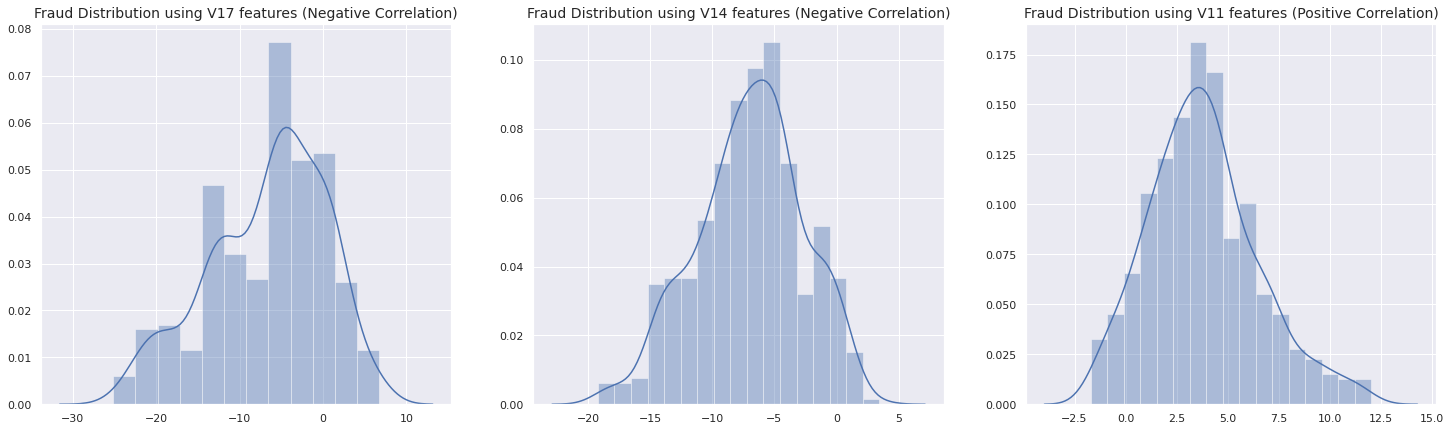

In [27]:
# Visualise the distribution of the 2 highest correlation

_, ax = plt.subplots(1, 3, figsize=(25,7))

# Find the correct location of Class 1 values
class1V14 = new_df['V14'].loc[new_df['Class'] == 1].values
class1V17 = new_df['V17'].loc[new_df['Class'] == 1].values
class1V11 = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(class1V14, ax=ax[1], norm_hist=True)
sns.distplot(class1V17, ax=ax[0], norm_hist=True)
sns.distplot(class1V11, ax=ax[2], norm_hist=True)
ax[1].set_title('Fraud Distribution using V14 features (Negative Correlation)', fontsize=14)
ax[0].set_title('Fraud Distribution using V17 features (Negative Correlation)', fontsize=14)
ax[2].set_title('Fraud Distribution using V11 features (Positive Correlation)', fontsize=14)

## Using Interquartile Range (IQR) to remove the outliers
 - Compute the 25% and 75% percentile and find the IQR

In [0]:
# Creating a new DF with the outliers removed
const = 1.5
(V14_lowr, V14_uppr) = np.percentile(class1V14, 25) - ((np.percentile(class1V14, 75) - np.percentile(class1V14, 25)) * const), np.percentile(class1V14, 75) + ((np.percentile(class1V14, 75) - np.percentile(class1V14, 25)) * const)
(V17_lowr, V17_uppr) = np.percentile(class1V17, 25) - ((np.percentile(class1V17, 75) - np.percentile(class1V17, 25)) * const), np.percentile(class1V17, 75) + ((np.percentile(class1V17, 75) - np.percentile(class1V17, 25)) * const)
(V11_lowr, V11_uppr) = np.percentile(class1V11, 25) - ((np.percentile(class1V11, 75) - np.percentile(class1V11, 25)) * const), np.percentile(class1V11, 75) + ((np.percentile(class1V11, 75) - np.percentile(class1V11, 25)) * const)

# Drop the outliers within the same DF
new_df = new_df.drop(new_df[(new_df['V14'] > V14_uppr) | (new_df['V14'] < V14_lowr)].index) 
new_df = new_df.drop(new_df[(new_df['V17'] > V17_uppr) | (new_df['V17'] < V17_lowr)].index)
new_df = new_df.drop(new_df[(new_df['V11'] > V11_uppr) | (new_df['V11'] < V11_lowr)].index)

In [29]:
new_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,Normal Amount,Normal Time
121,77.0,-0.427191,0.745708,1.761811,-0.165130,0.058298,-0.213413,0.647323,0.073464,-0.291864,0.064800,1.527192,-0.131506,-1.696914,0.482121,0.586418,0.034541,-0.306278,-0.206030,-0.118939,0.052828,-0.201681,-0.432070,0.013164,0.161606,-0.401310,0.047423,0.102549,-0.116571,9.12,0,0.000355,0.000446
248296,153875.0,-0.613696,3.698772,-5.534941,5.620486,1.649263,-2.335145,-0.907188,0.706362,-3.747646,-4.230984,4.436319,-4.503801,-0.954361,-9.861372,-0.505329,0.269282,0.591319,1.795992,-1.085208,0.354773,0.319261,-0.471379,-0.075890,-0.667909,-0.642848,0.070600,0.488410,0.292345,0.00,1,0.000000,0.890522
239,160.0,1.171439,0.474974,0.011761,1.264303,0.116234,-0.865986,0.554393,-0.276375,-0.471302,0.029104,0.252013,0.740676,0.588884,0.480297,0.799412,-0.592090,0.032839,-1.012363,-0.799293,-0.119439,0.070051,0.278843,-0.097491,0.426278,0.744938,-0.274728,0.008472,0.015492,20.00,0,0.000778,0.000926
239501,150139.0,-6.682832,-2.714268,-5.774530,1.449792,-0.661836,-1.148650,0.849686,0.433427,-1.315646,-2.796332,-0.448794,-2.562602,0.243483,-1.181669,0.004373,-2.302596,-4.446192,-1.710463,0.982729,-1.928527,0.220526,1.187013,0.335821,0.215683,0.803110,0.044033,-0.054988,0.082337,237.26,1,0.009235,0.868900
143336,85285.0,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,-8.537758,6.348979,-8.681609,0.251179,-11.608002,-0.351569,-5.363566,-11.939092,-3.583603,0.897402,0.135711,0.954272,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,252.92,1,0.009845,0.493570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41395,40662.0,-4.446847,-0.014793,-5.126307,6.945130,5.269255,-4.297177,-2.591242,0.342671,-3.880663,-3.976525,5.730084,-5.031868,-1.135439,-10.787051,0.265456,-1.104217,0.636413,0.994101,-0.688721,-0.108006,0.247913,-0.049586,-0.226017,-0.401236,0.856124,0.661272,0.492560,0.971834,1.00,1,0.000039,0.235323
142557,84789.0,-1.430864,-0.802529,1.123320,0.389760,-0.281214,-0.055123,1.326232,0.195700,-0.546890,-0.713474,1.274629,0.023682,-1.521696,0.727242,0.166505,0.348038,-0.566390,0.216016,-1.140376,0.634184,0.325575,0.014002,0.844946,0.114963,0.156365,-0.619437,-0.120351,0.035594,354.33,1,0.013792,0.490700
368,269.0,1.320626,-1.174338,0.713431,-2.177941,-1.511234,0.059314,-1.308064,0.298796,0.788814,-0.200099,0.835251,0.506268,-0.892308,0.083951,0.871965,-1.856353,0.163268,1.670423,0.061359,-0.577243,-0.354221,-0.365280,0.064822,-0.322003,0.152701,-0.003131,0.075103,0.010941,2.60,0,0.000101,0.001557
239499,150138.0,-2.150855,2.187917,-3.430516,0.119476,-0.173210,0.290700,-2.808988,-2.679351,-0.556685,-4.485483,1.903999,-2.644219,-0.982273,-4.691151,-0.693080,-2.553251,-3.483436,-0.064852,1.490329,0.532145,-0.073205,0.561496,-0.075034,-0.437619,0.353841,-0.521339,0.144465,0.026588,50.00,1,0.001946,0.868894


## Clustering using t-SNE 
 - Reduce dimentionality using 
  - Feature Extraction
  - Feature Selection

- As opposed to PCA, t-SNE is used since we would prefer using a non-linear clustering
- Hyper-params such as perplexities could be verified using many iterations

In [0]:
# Creating a training and testing variables
# https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py

x_train = new_df.drop(columns='Class', axis=1) # X 
y = new_df['Class'] # Ground truth or label

X_embedded = TSNE(n_components=2, random_state=40).fit_transform(x_train)

Text(0.5, 1.0, 't SNE Visualisation')

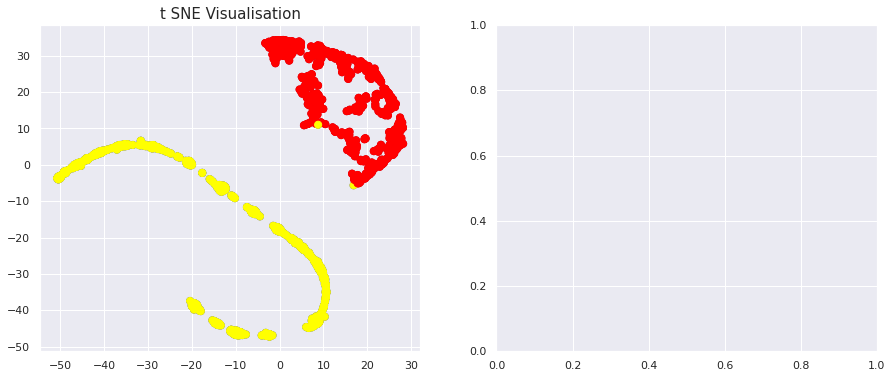

<Figure size 576x432 with 0 Axes>

In [37]:
# Visualising the embeddings
_, ax = plt.subplots(1, 2, figsize=(15,6))

x_train['tsne-2d-one'] = X_embedded[:, 0] # Fraud Class
x_train['tsne-2d-two'] = X_embedded[:, 1] # Non Fraud Class

plt.figure(figsize=(8,6))
ax[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=(y == 0), s=50, cmap='coolwarm') # Visualise both the distribution of Fraud and Non Fraud
ax[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=(y == 1), s=50, cmap='autumn')
ax[0].set_title('t SNE Visualisation', fontsize=15)

## Support Vector Machines
- Aims to find the best fit line to separate the classes
- By training the hyperplane (the best fit line), we can find the line that results in the largest margin between the multi-classes
- SVM has something called as kernal. Kernals are used create a non-linear separation of the classes. 

In [32]:
model = svm.SVC(kernel='rbf', C=1) # C represents the SVM regularization parameter. Hyperparams can be tuned using GridSearchCV

# Split the data into training and testing data 
X_train, X_test, y_train, y_test = train_test_split(x_train, y, test_size=0.3, random_state=30)
model.fit(X_train, y_train)

# Perform 5 fold cross validation to ensure the data is properly fitted to reduce the chances of overfitting
accuracyScore = cross_val_score(model, X_train, y_train, cv=5)
print('Cross Validation score = {}'.format(accuracyScore.mean() * 100))

Cross Validation score = 97.06526406182911


In [0]:
y_pred = model.predict(X_test)

## From the confusion matrix above, we can indentify the accuracy of our predictions

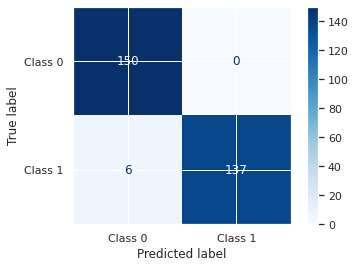

In [40]:
disp = plot_confusion_matrix(model, X_test, y_test, display_labels=['Class 0', 'Class 1'], cmap=plt.cm.Blues, values_format='g')